# Project 1: Housing prices

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from isc301.config import houses_raw_path

In [2]:
df: pd.DataFrame = pd.read_csv(houses_raw_path)
print(len(df), "rows")
df.head()

1364 rows


,surf_hab,qualite_materiau,surface_sous_sol,qualite_globale,n_garage_voitures,n_toilettes,n_cheminees,n_pieces,n_cuisines,n_chambres_coucher,annee_vente,prix,type_toit,type_batiment,qualite_cuisine,surface_jardin
0,1710,7,856,5,2,1,0,8,1,3,2008,208500,2 pans,individuelle,bonne,451.271415
1,1262,6,1262,8,2,0,1,6,1,3,2007,181500,2 pans,individuelle,moyenne,0.000000
2,1786,7,920,5,2,1,1,6,1,3,2008,223500,2 pans,individuelle,bonne,466.368854
3,1717,7,756,5,3,0,1,7,1,3,2006,140000,2 pans,individuelle,bonne,152.302986
4,2198,8,1145,5,3,1,1,9,1,4,2008,250000,2 pans,individuelle,bonne,378.184663


In [3]:
df["qualite_cuisine_num"] = df["qualite_cuisine"].map(
    {"mediocre": 0, "moyenne": 1, "bonne": 2, "excellente": 3}
)

In [4]:
class Col:
    surface = "surf_hab"
    mat_quality = "qualite_materiau"
    surface_below = "surface_sous_sol"
    glob_quality = "qualite_globale"
    car_spaces = "n_garage_voitures"
    toilets = "n_toilettes"
    fireplaces = "n_cheminees"
    rooms = "n_pieces"
    kitchens = "n_cuisines"
    bedrooms = "n_chambres_coucher"
    year = "annee_vente"
    price = "prix"
    roof = "type_toit"
    kind = "type_batiment"
    kitchen_quality = "qualite_cuisine_num"
    surface_garden = "surface_jardin"
    _numerical = []
    _categorical = []


Col._numerical = [
    Col.surface,
    Col.mat_quality,
    Col.surface_below,
    Col.glob_quality,
    Col.car_spaces,
    Col.toilets,
    Col.fireplaces,
    Col.rooms,
    Col.kitchens,
    Col.bedrooms,
    Col.year,
    Col.price,
    Col.kitchen_quality,
    Col.surface_garden,
]

Col._categorical = [Col.roof, Col.kind]

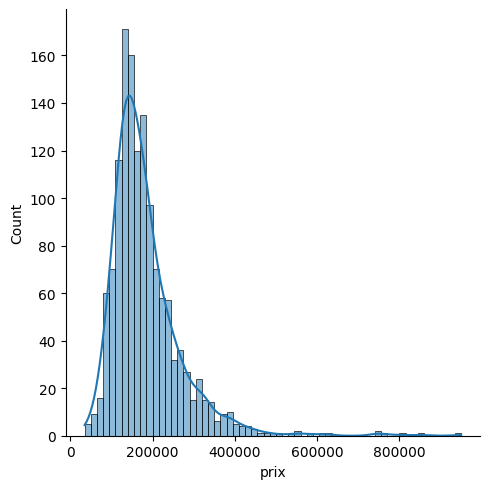

In [5]:
sns.displot(df, x=Col.price, kde=True).set_titles("Price distribution")

<Axes: xlabel='n_pieces', ylabel='prix'>

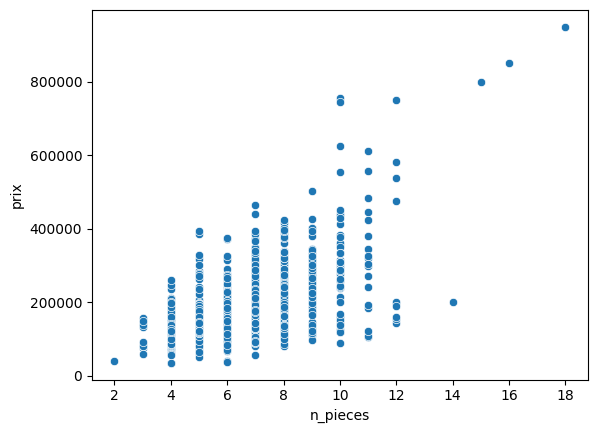

In [6]:
sns.scatterplot(df, x=Col.rooms, y=Col.price)

<Axes: xlabel='surf_hab', ylabel='prix'>

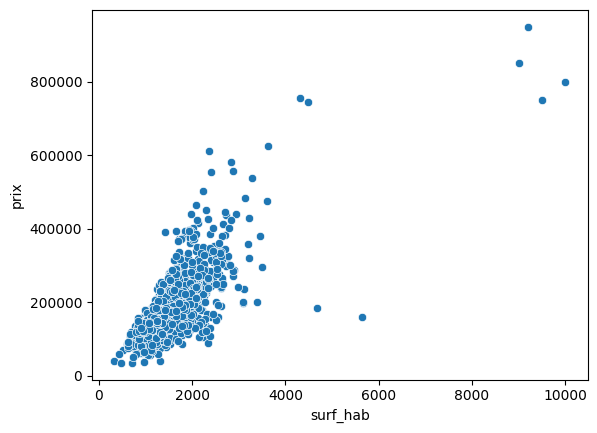

In [7]:
sns.scatterplot(df, x=Col.surface, y=Col.price)

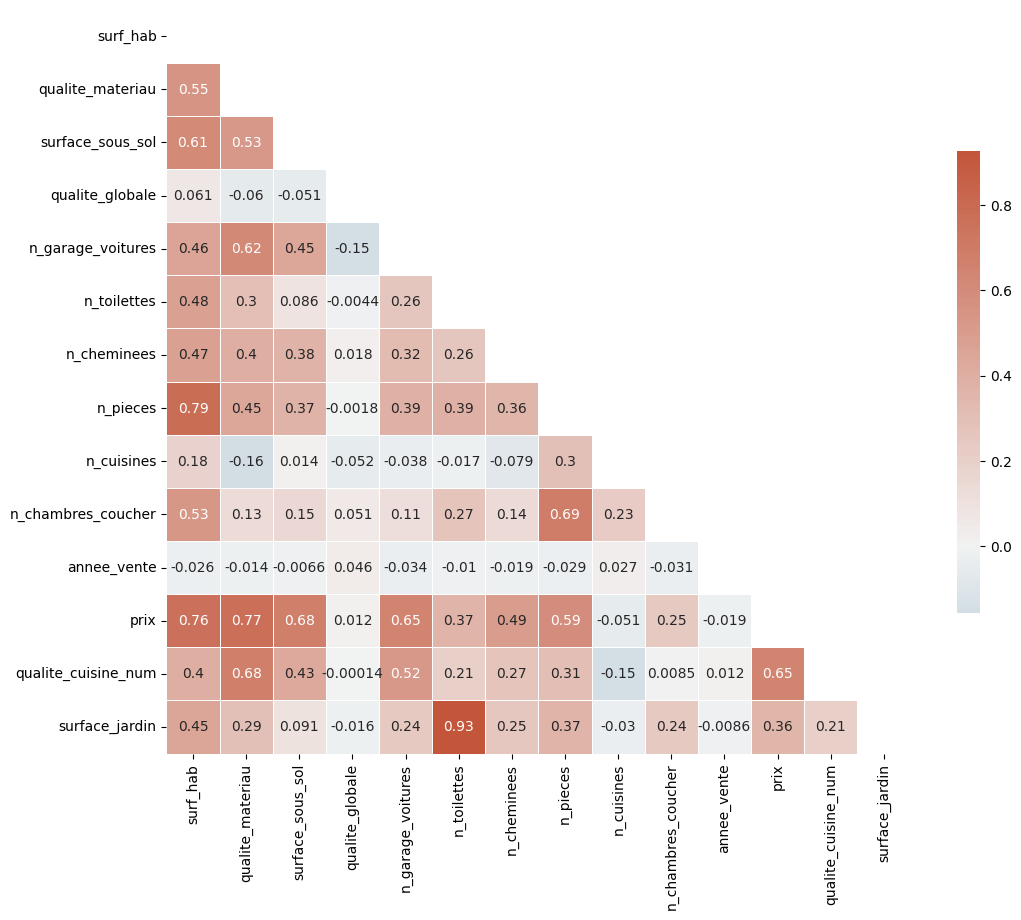

In [8]:
from isc301.utils import correlation_grid


correlation_grid(df[Col._numerical], figsize=(12, 12))

<Axes: xlabel='surface_jardin', ylabel='n_toilettes'>

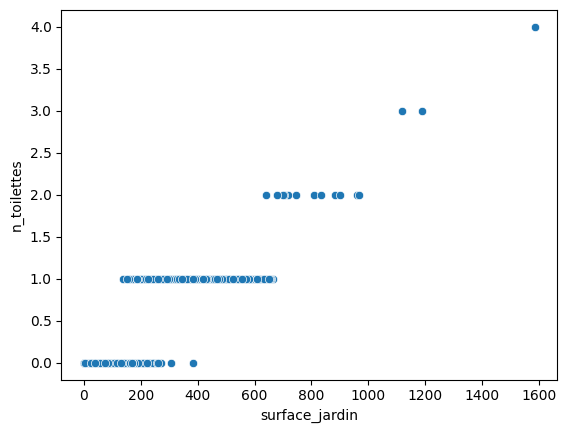

In [9]:
# There appears to be a high correlation between the garden's surface and the number of toilets
sns.scatterplot(df, x=Col.surface_garden, y=Col.toilets)

In [10]:
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

df2 = df.copy()
df2[Col._numerical] = StandardScaler().fit_transform(df[Col._numerical])
df2[Col._categorical] = OrdinalEncoder().fit_transform(df[Col._categorical])
df2 = df2[(np.abs(stats.zscore(df2[Col._numerical])) < 3).all(axis=1)]

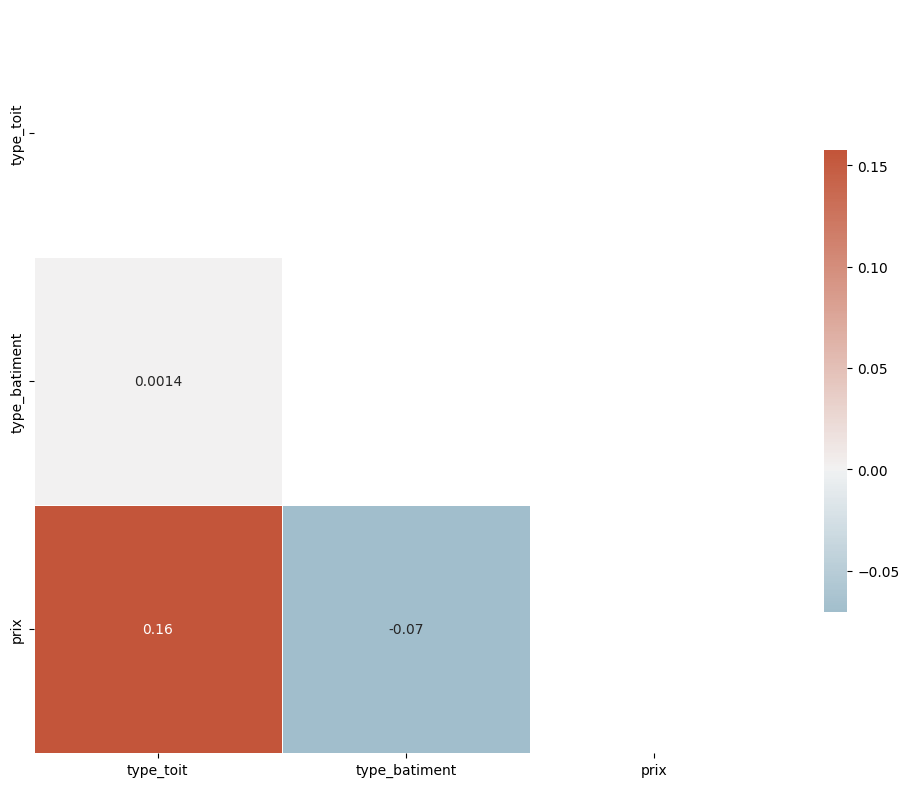

In [11]:
correlation_grid(df2[Col._categorical + [Col.price]], figsize=(12, 12))

In [12]:
from numpy.polynomial.polynomial import polyfit
from isc301.utils import lsm_linear, model_linear, model_poly, Model

surface: np.ndarray = df2[Col.surface]
price: np.ndarray = df2[Col.price]
linear: Model = model_linear(*lsm_linear(surface, price))
poly_coeffs: np.ndarray = polyfit(df2[Col.surface], df2[Col.price], deg=4)
poly: Model = model_poly(*poly_coeffs)

In [13]:
from isc301.utils import evaluate_mse

linear_eval: float = evaluate_mse(linear, surface, price)
poly_eval: float = evaluate_mse(poly, surface, price)
print(f"Linear: {linear_eval}")
print(f"Polynomial: {poly_eval}")

Linear: 0.26712451100294426
Polynomial: 0.26441704969963026


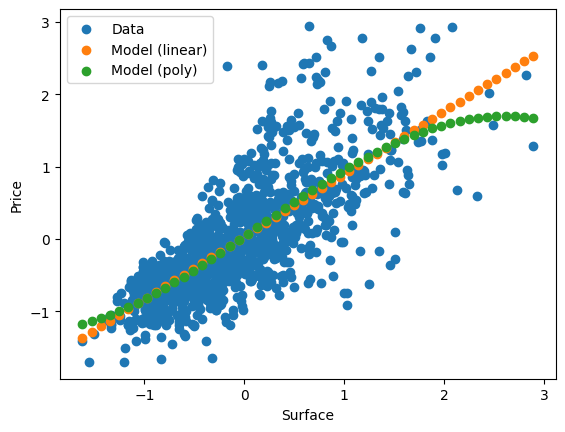

In [14]:
def plot_poly():
    x = np.linspace(surface.min(), surface.max())
    plt.xlabel("Surface")
    plt.ylabel("Price")
    plt.scatter(surface, price, label="Data")
    plt.scatter(x, linear(x), label="Model (linear)")
    plt.scatter(x, poly(x), label="Model (poly)")
    plt.legend()


plot_poly()

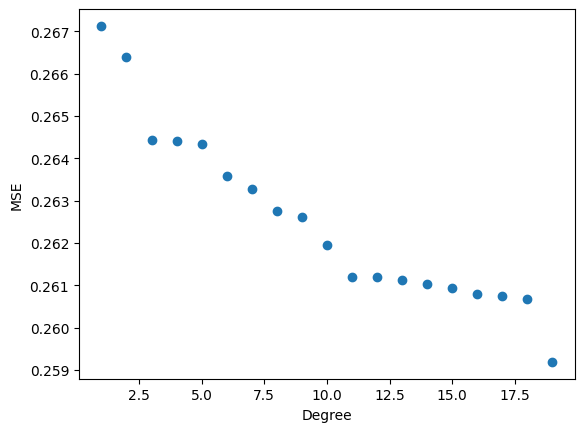

In [15]:
def try_degrees():
    degrees = range(1, 20)
    evals = []
    for i in degrees:
        coeffs: np.ndarray = polyfit(surface, price, deg=i)
        model: Model = model_poly(*coeffs)
        eval: float = evaluate_mse(model, surface, price)
        evals.append(eval)
    plt.xlabel("Degree")
    plt.ylabel("MSE")
    plt.scatter(degrees, evals)


try_degrees()

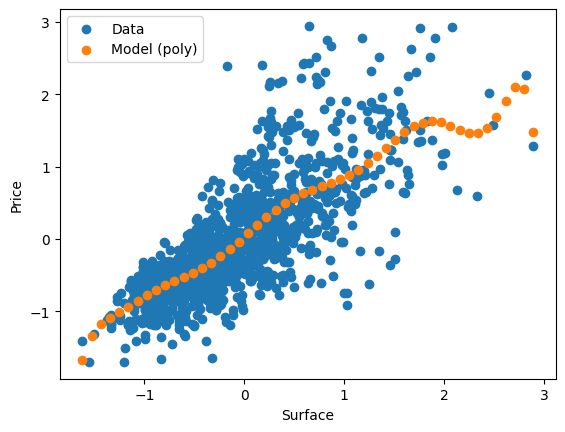

In [16]:
def test_20():
    coeffs: np.ndarray = polyfit(surface, price, deg=10)
    model: Model = model_poly(*coeffs)
    x = np.linspace(surface.min(), surface.max())
    plt.xlabel("Surface")
    plt.ylabel("Price")
    plt.scatter(surface, price, label="Data")
    plt.scatter(x, model(x), label="Model (poly)")
    plt.legend()


test_20()

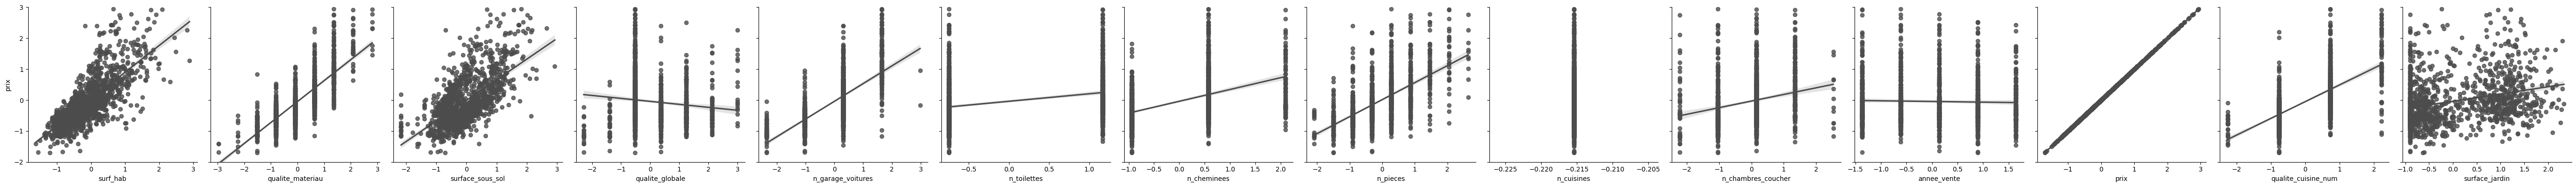

In [17]:
g = sns.PairGrid(df2, y_vars=[Col.price], x_vars=Col._numerical, height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-2, 3))

(410, 2) (410,)
Surface correlation with error: [3.09795688e+09]
Quality correlation with error: [8379034.74204584]


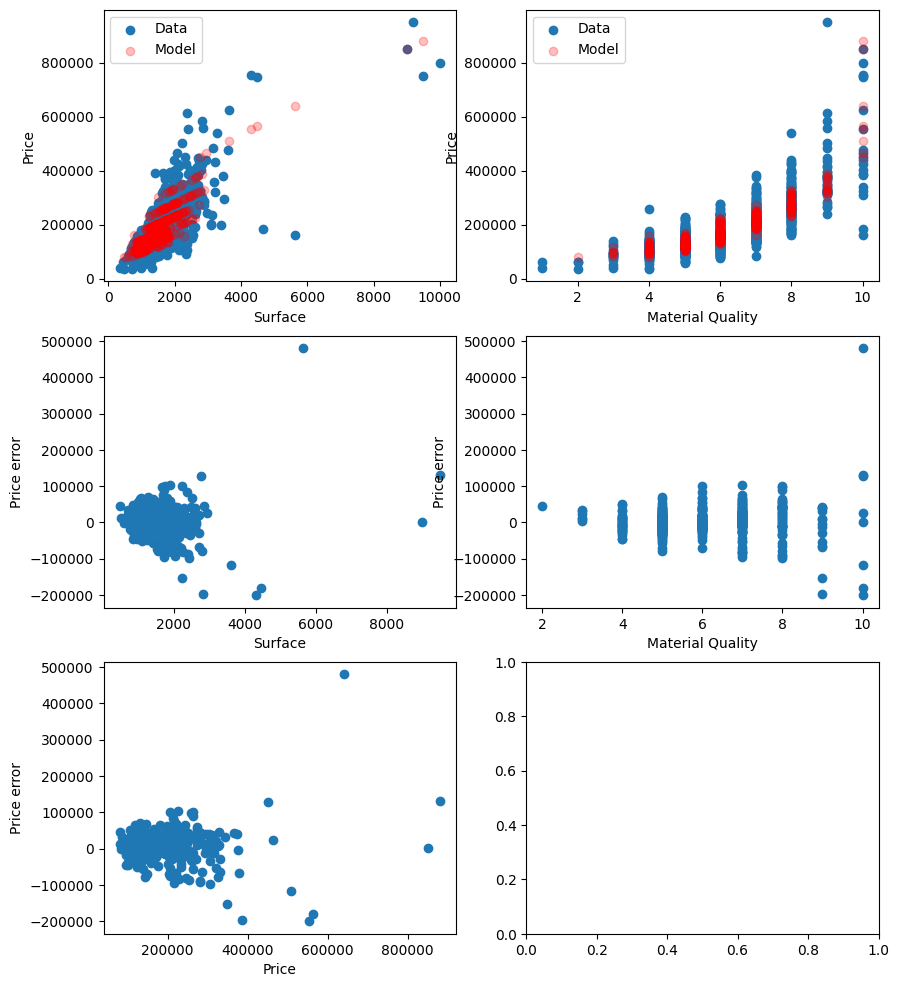

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def poly2d_fit(x, y):
    features = PolynomialFeatures(2)
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.3, random_state=42
    )
    X_poly = features.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_poly, y_train)

    X_poly_test = features.fit_transform(X_test)
    return X_test, model.predict(X_poly_test), y_test


def polynomial_model():
    fig, axs = plt.subplots(3, 2, figsize=(10, 12))
    x2, y2, real_y = poly2d_fit(df[[Col.surface, Col.mat_quality]], df[Col.price])
    x2 = np.array(x2)
    surface = x2[:, 0]
    quality = x2[:, 1]
    print(x2.shape, y2.shape)
    axs[0][0].scatter(df[Col.surface], df[Col.price], label="Data")
    axs[0][0].scatter(surface, y2, label="Model", c="r", linewidth=1, alpha=0.25)
    axs[0][0].set_xlabel("Surface")
    axs[0][0].set_ylabel("Price")
    axs[0][0].legend()
    axs[0][1].scatter(df[Col.mat_quality], df[Col.price], label="Data")
    axs[0][1].scatter(quality, y2, label="Model", c="r", linewidth=1, alpha=0.25)
    axs[0][1].set_xlabel("Material Quality")
    axs[0][1].set_ylabel("Price")
    axs[0][1].legend()

    diffs = y2 - real_y
    axs[1][0].scatter(surface, diffs)
    axs[1][0].set_xlabel("Surface")
    axs[1][0].set_ylabel("Price error")
    axs[1][1].scatter(quality, diffs)
    axs[1][1].set_xlabel("Material Quality")
    axs[1][1].set_ylabel("Price error")
    axs[2][0].scatter(y2, diffs)
    axs[2][0].set_xlabel("Price")
    axs[2][0].set_ylabel("Price error")

    surface_error_corr = np.correlate(surface, diffs)
    quality_error_corr = np.correlate(quality, diffs)
    print(f"Surface correlation with error: {surface_error_corr}")
    print(f"Quality correlation with error: {quality_error_corr}")

    # df3 = df


df3 = polynomial_model()

In [19]:
"""
def plot3d():
    x2, y2 = poly2d()
    x2 = np.array(x2)

    z = y2
    x = x2[:, 0]
    y = x2[:, 1]

    ax = plt.axes(projection="3d")

    # Data for three-dimensional scattered points
    ax.scatter3D(df2[Col.surface], df2[Col.mat_quality], df2[Col.price], label="Data")
    ax.scatter3D(x, y, z, c=z, cmap="inferno", label="Model")
    ax.legend()
"""


# plot3d()

'\ndef plot3d():\n    x2, y2 = poly2d()\n    x2 = np.array(x2)\n\n    z = y2\n    x = x2[:, 0]\n    y = x2[:, 1]\n\n    ax = plt.axes(projection="3d")\n\n    # Data for three-dimensional scattered points\n    ax.scatter3D(df2[Col.surface], df2[Col.mat_quality], df2[Col.price], label="Data")\n    ax.scatter3D(x, y, z, c=z, cmap="inferno", label="Model")\n    ax.legend()\n'

Linear model
(1023,) (341,) (1023,) (341,)
Train Score: 37861.15191307499
Validate Score: 37032.211035382454

Poly linear regression
(1023, 5) (341, 5) (1023,) (341,)
Train Score: 16039.78326890548
Validate Score: 191728424.92920166

Poly Lasso
(1023, 5) (341, 5) (1023,) (341,)


/home/louis/Documents/ML/301-Week1-ML-project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.671e+10, tolerance: 7.045e+08
  model = cd_fast.enet_coordinate_descent(


Train Score: 21906.784634989508
Validate Score: 44816.321697503416

Poly Ridge
(1023, 5) (341, 5) (1023,) (341,)
Train Score: 26027.1098362813
Validate Score: 24633.376153794976
Polynomial model:
[ 0.00000000e+00  4.08967045e+04  4.67144963e+04  2.27196426e+04
  3.12071542e+04 -1.62549514e+01  8.60742860e+03  2.74341042e+04
  1.10963002e+04  2.17455930e+04  9.05086370e+03  4.29556900e+04
  2.25456666e+04  3.83095895e+04 -1.60979038e+03  1.01151585e+04
  1.58236025e+04  4.10310393e+03  1.82588981e+04  1.86660007e+03
 -1.62549514e+01  3.20356413e+02  4.44598047e+03  8.50885538e+02
  5.03385406e+03  3.22204191e+03  1.71392454e+04  6.54630214e+03
  1.57825140e+04  4.77992580e+03  2.26489506e+03  6.38801949e+03
  2.85746868e+03  1.13053257e+04  2.83149395e+03  9.05086370e+03
  3.17764564e+04  1.57110278e+04  3.17281909e+04 -3.46831306e+03
  8.30439449e+03  1.48843779e+04  1.22603333e+03  2.16231827e+04
  3.62238661e+02 -1.60979038e+03  3.50080086e+03  6.68236258e+03
  2.06300471e+03  8.6688

,surf_hab,qualite_materiau,surface_sous_sol,qualite_globale,n_garage_voitures,n_toilettes,n_cheminees,n_pieces,n_cuisines,n_chambres_coucher,annee_vente,prix,type_toit,type_batiment,qualite_cuisine,surface_jardin,qualite_cuisine_num,is_premium,predicted,residual
523,4676,10,3138,5,3,1,1,11,1,3,2007,184750,4 pans,individuelle,excellente,458.459867,3,0,519215.894275,334465.894275
1298,5642,10,6110,5,2,1,3,12,1,3,2008,160000,4 pans,individuelle,excellente,428.339231,3,0,466057.834120,306057.834120
1342,2007,10,1017,5,3,1,1,10,1,3,2009,310000,2 pans,individuelle,excellente,419.902156,3,0,455646.909776,145646.909776
1360,10000,10,5000,10,4,3,3,15,2,6,2008,800000,2 pans,individuelle,excellente,1190.954402,3,1,924449.135998,124449.135998
632,1411,7,1386,5,2,0,1,6,1,3,2009,82500,4 pans,individuelle,moyenne,0.000000,1,0,194726.330424,112226.330424


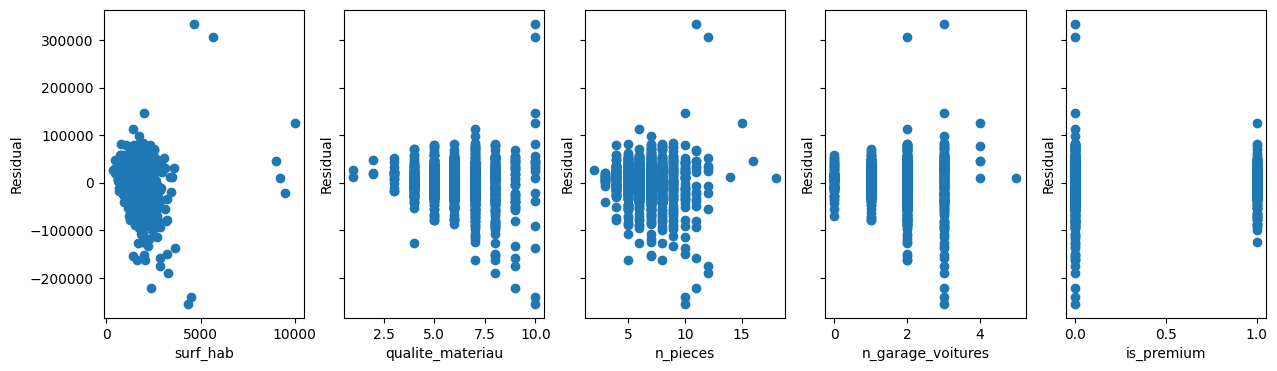

In [20]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from isc301.hel_prediction import LinearModel, Model, PolyModel


def test_models():
    df2: pd.DataFrame = df.assign(is_premium=np.where(df["qualite_globale"] > 6, 1, 0))
    linear: Model = LinearModel(Col.surface, Col.price)
    x_vars: list[str] = [
        Col.surface,
        Col.mat_quality,
        Col.rooms,
        Col.car_spaces,
        "is_premium",
    ]
    scaler_cls = MinMaxScaler
    poly_lin: Model = PolyModel(
        x_vars, Col.price, LinearRegression(), scaler_cls, degree=6
    )
    poly_lasso: Model = PolyModel(
        x_vars, Col.price, Lasso(1, max_iter=10_000), scaler_cls, degree=6
    )
    poly_ridge: Model = PolyModel(
        x_vars, Col.price, Ridge(10, max_iter=10_000), scaler_cls, degree=6
    )
    print("Linear model")
    linear.process_dataset(df2, mean_absolute_error)
    print()

    print("Poly linear regression")
    poly_lin.process_dataset(df2, mean_absolute_error)
    print()

    print("Poly Lasso")
    poly_lasso.process_dataset(df2, mean_absolute_error)
    print()

    print("Poly Ridge")
    df_ridge: pd.DataFrame = poly_ridge.process_dataset(df2, mean_absolute_error)

    poly_ridge.explain()
    # return df2.sort_values("residual", ascending=False).head()
    df3 = df_ridge.copy()
    # df4["residual"] = df4["residual"].abs()
    # df4 = df3.sort_values("residual", ascending=False)
    # sns.scatterplot(df4, x=df.index, y="residual")
    poly_ridge.plot_residuals()
    df3["residual"] = df3["residual"].abs()
    df3 = df_ridge.sort_values("residual", ascending=False)
    # sns.scatterplot(df4, x=df.index, y="residual")
    return df3.head()


test_models()